<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification?scriptVersionId=130445180" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Work in progress 🚧

**<center><font size=5>RSNA-MICCAI Brain Tumor Classification</font></center>**

<center><img src="https://lingualab.ca/fr/project/language-recovery-psa/featured_hu67ab33455cf328a3b8dbb37d23762824_484672_720x0_resize_lanczos_2.png" alt="equal-2495950-1920" border="0" width="700"></center>

***

**Table of Contents**
- <a href='#intro'>1. Project overview and objectives</a> 
    - <a href='#survey'>1.1. The aim of the survey</a>
    - <a href='#data'>1.2. Data set overview</a>
- <a href='#bi'>2. </a>
- <a href='#score'>3. </a>
    - <a href='#method'>3.1.</a>
    - <a href='#dl'>3.2. </a>
    - <a href='#ra'>3.3. </a>

# Introduction

The RSNA-MICCAI Brain Tumor Radiogenomic Classification Contest is a multi-class classification problem, giving MRIs based on radiomic features, where the goal is to predict the presence of MGMT promoter methylation.

There are three classes: 
- LGG (low-grade glioma)
- HGG (high-grade glioma) 
- WT (hemangioblastoma)

The dataset we will be working with consists of MRI datasets provided by the Radiological Society of North America (RSNA®) and the Medical Image Computing and Computer Assisted Intervention Society (the MICCAI Society). The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

Here's the competition [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

# Contributors

- [David Goudard](https://www.kaggle.com/goudgoud)
- [Louis-Marie Renaud](https://www.kaggle.com/louismarierenaud)
- [Yannick Stephan](https://github.com/YanSteph)


# Dataset

The exact mpMRI scans included are:
- Fluid Attenuated Inversion Recovery (FLAIR)
    * What it is: These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * What it highlights: It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.
- T1-weighted pre-contrast (T1w)
    * What it is: These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * What it highlights: It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.
- T1-weighted post-contrast (T1Gd)
    * What it is: These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * What it highlights: It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.
- T2-weighted (T2)
    * What it is: These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * What it highlights: It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

# Necessary imports

In [84]:
# Operating System and File System
import os 

# Data Manipulation and Analysis
import numpy as np  
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Warnings
import warnings  # For suppressing warnings

# JSON Handling
import json  # For working with JSON data

# Encoding and Decoding Binary Data
import base64  # For encoding and decoding binary data

# Interactive Widgets and Display
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
from IPython.display import HTML, display  # For displaying HTML content

# Deep Learning Framework
import torch  # For working with PyTorch deep learning framework

# DICOM File Handling
import pydicom  # For reading DICOM files
from pydicom import dcmread  # For reading DICOM files

# Image Processing and Filtering
import SimpleITK as sitk  # For image filtering
from PIL import Image  # For image processing using the Python Imaging Library (PIL)

# Machine Learning and Data Splitting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm

# Additional Libraries
!pip install pyradiomics > /dev/null  # Installing the pyradiomics library for radiomics feature extraction
import radiomics  # For extracting radiomics features from medical images

In [85]:
# Configuration

# Show all columns
pd.set_option('display.max_columns', None)
# Suppressing Warnings
warnings.filterwarnings('ignore')

## Methods definition

In [86]:
# ===============================================
# Images methods
# ===============================================

def get_processed_image(patient_id):
    """
    Retrieves and processes the images for a given patient, grouping them for segmentation.

    Args:
        patient_id (str): The ID of the patient (BraTS21ID).

    Returns:
        numpy.ndarray: A processed image composed of the different images of the patient.
    """
    # SEGMENTATION MODEL LIMITED TO 3 LAYERS
    # T2W SKIPPED

    # Paths for image sequences
    t1w_path = f'{train_path}/{str(patient_id).zfill(5)}/T1w'
    flair_path = f'{train_path}/{str(patient_id).zfill(5)}/FLAIR'
    t1wce_path = f'{train_path}/{str(patient_id).zfill(5)}/T1wCE'
    #t2w_path = f'{train_path}/{str(patient_id).zfill(5)}/T2w'

    # Retrieve image sequences
    t1w_image = sequence_filenames(t1w_path)
    flair_image = sequence_filenames(flair_path)
    t1wce_image = sequence_filenames(t1wce_path)
    #t2w_image = sequence_filenames(t2w_path)

    # Resampling
    re_sampled_flair = re_sample_image(flair_image, t1w_image)
    re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
    #re_sampled_t2w = re_sample_image(t2w_image, t1w_image)

    # Normalization
    t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
    flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
    t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
    #t2w_array = normalize(sitk.GetArrayFromImage(re_sampled_t2w))

    sequence_stacked = np.stack([t1w_array, flair_array, t1wce_array]) #, t2w_array])

    central_slice = t1w_array.shape[0] // 2
    rvb = sequence_stacked[:, central_slice, :, :].transpose(1, 2, 0)
    image = Image.fromarray((rvb * 255).astype(np.uint8))
    return np.array([np.moveaxis(np.array(image.resize((256, 256))), -1, 0)])


def sequence_filenames(path) :
    """
    Retrieves a sequence of images for a given directory.

    Args:
        path (str): The path to the directory containing the DICOM data set.

    Returns:
        SimpleITK.Image: A sequence of images corresponding to the DICOM files in the directory.

    Raises:
        FileNotFoundError: If the specified path does not exist.
    """
    filenames = sitk_reader.GetGDCMSeriesFileNames(path)
    sitk_reader.SetFileNames(filenames)
    image = sitk_reader.Execute()
    
    return image    

def normalize(dataset) :
    """
    Normalizes the data obtained from the images.

    Args:
        dataset (numpy.ndarray): The dataset to be normalized.

    Returns:
        numpy.ndarray: The normalized dataset.
    """
    return (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))


def re_sample_image(image, ref_img):
    """
    Resamples the image to match the dimensions and properties of the reference image.

    Args:
        image (SimpleITK.Image): The image to be resampled.
        ref_img (SimpleITK.Image): The reference image used for resampling.

    Returns:
        SimpleITK.Image: The resampled image.
    """
    re_sampler = sitk.ResampleImageFilter()
    re_sampler.SetReferenceImage(ref_img)
    re_sampler.SetDefaultPixelValue(image.GetPixelIDValue())
    re_sampler.SetInterpolator(sitk.sitkLinear)
    re_sampler.SetOutputSpacing(ref_img.GetSpacing())
    re_sampler.SetOutputDirection(ref_img.GetDirection())
    re_sampler.SetOutputOrigin(ref_img.GetOrigin())
    re_sampler.SetSize(ref_img.GetSize())
    re_sampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
    re_sampled_image = re_sampler.Execute(image)
    
    return re_sampled_image

def segmentation_process(image_resized):
    """
    Obtains the segmented image.

    Args:
        image_resized (numpy.ndarray): The resized image.

    Returns:
        numpy.ndarray: The segmented image.
    """
    segmentation = segmentation_model(torch.Tensor(image_resized))
    return segmentation
    
# ===============================================
# Dataset creation methods
# ===============================================

def init_dataset_radiomics() :
    """
    Initializes the DataFrame structures for radiomics data acquisition.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    df_shapes_columns = ['ID','BraTS21ID','MeshSurface','PixelSurface','Perimeter','PerimeterSurfaceRatio','Sphericity',
                              'SphericalDisproportion','MaximumDiameter','MajorAxisLength','MinorAxisLenth','Elongation']
    df_shapes = pd.DataFrame(columns=df_shapes_columns) 


    df_textures_columns = ['ID','Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
    df_textures = pd.DataFrame(columns=df_textures_columns) 


    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    df_first_orders_features = pd.DataFrame(columns=df_first_orders_features_columns) 
    

def add_patient_data(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape2D.RadiomicsShape2D(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )
    
    shape2D = {}
    shape2D['ID'] = int(ID)
    shape2D['BraTS21ID'] = int(ID)
    shape2D['MeshSurface'] = results.getMeshSurfaceFeatureValue()
    shape2D['PixelSurface'] = results.getPixelSurfaceFeatureValue()
    shape2D['Perimeter'] = results.getPerimeterFeatureValue()
    shape2D['PerimeterSurfaceRatio'] = results.getPerimeterSurfaceRatioFeatureValue()
    shape2D['Sphericity'] = results.getSphericityFeatureValue()
    shape2D['SphericalDisproportion'] = results.getSphericalDisproportionFeatureValue()
    shape2D['MaximumDiameter'] = results.getMaximumDiameterFeatureValue()
    shape2D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape2D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape2D['Elongation'] = results.getElongationFeatureValue()
    
    df_shapes=df_shapes.append(shape2D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)
    
    
# ===============================================
# Show methods
# ===============================================

def show_segmentation(img_src,segmentation) :
    """
    Displays the resized source images and the segmentation image in a single line.

    Args:
        img_src (numpy.ndarray): Resized source images.
        segmentation (torch.Tensor): Segmentation image.

    Returns:
        None
    """
    titles=['T1w','FLAIR','T1wce'] #,'T2w']
    for i in range(3):
        plt.subplot(1,4,1+i)
        plt.imshow(img_src[0, i])
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
    
    plt.subplot(1,4,4)
    plt.imshow(segmentation.detach().numpy()[0,0])
    plt.title('Segmentation')
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.show()
    
def show_download_link(df, title = "Download CSV file", filename = "data.csv"):
    """
    Displays a download link for a DataFrame as a CSV file.

    Args:
        df (pandas.DataFrame): The DataFrame to be downloaded.
        title (str): The title of the download link (default: "Download CSV file").
        filename (str): The name of the downloaded file (default: "data.csv").

    Returns:
        None
    """
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    display(HTML(html))
    
# ===============================================
# Analysis
# ===============================================

def filter_correlation_matrix(correlation_matrix, correlation_threshold):
    """
    Filters a correlation matrix by keeping only the absolute values greater than or equal to the correlation threshold.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold for filtering the matrix.

    Returns:
        pd.DataFrame: The filtered correlation matrix.

    """
    filtered_correlation_matrix = correlation_matrix[abs(correlation_matrix) >= correlation_threshold]

    return filtered_correlation_matrix

def find_highly_correlated_groups(correlation_matrix, correlation_threshold = 0.8, filter_duplicated_group = True, convert_indices_to_column_names = True):
    """
    Finds groups of highly correlated variables from a correlation matrix.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold to consider as highly correlated.
        filter_duplicated_group (bool): Indicates whether to filter out duplicated values in the correlated groups.
        convert_indices_to_column_names (bool): Indicates whether to convert indices to column names.

    Returns:
        List[List[str]]: A list of groups, where each group contains the names of variables that are highly correlated.

    """
    n = correlation_matrix.shape[0]  # Number of variables in the correlation matrix
    groups_correlated = []  # List to store the correlated groups
    
    # Retrieve column names
    column_names = correlation_matrix.columns
    
    # Traverse each variable
    for i in range(n):
        if column_names[i] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
            group = [i]  # Create a new group containing the current variable (i)
            for j in range(i+1, n):
                if column_names[j] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
                    correlation = correlation_matrix.iloc[i, j]  # Retrieve the correlation between variables i and j
                    if abs(correlation) >= correlation_threshold:  # Strong correlation condition (adjust as needed)
                        group.append(j)  # Add variable j to the group
            
            groups_correlated.append(group)  # Add the group to the list of correlated groups
    
    # Filter out duplicated values in the correlated groups
    if filter_duplicated_group:
        filtered_groups_correlated = []
        for group in groups_correlated:
            filtered_group = list(set(group))  # Convert to a set to eliminate duplicates, then convert back to a list
            filtered_groups_correlated.append(filtered_group)
        groups_correlated = filtered_groups_correlated # Reset by new one
    
    # Convert indices to column names
    if convert_indices_to_column_names:
        groups_correlated = [[column_names[i] for i in group] for group in groups_correlated]
    
    return groups_correlated

def fonc_test_normality(df,graphic=True) : 

    describe = df.describe()
    
    for col in df.columns :

        describe.loc['skewness',col] = stats.skew(df[col])
        describe.loc['kurtosis', col] = stats.kurtosis(df[col],fisher=False)#Vrai kurtosis
        describe.loc['excess_kurtosis',col] = stats.kurtosis(df[col])#Vrai kurtosis
        shapiro_test =  stats.shapiro(df[col])[1]
        describe.loc['shapiro_test',col] = shapiro_test
        describe.loc['normalite',col] = 'Oui' if shapiro_test > 0.05 else 'Non'

        if graphic : 
            figure_size = (6, 2)

            fig = plt.figure(figsize=figure_size)

            plt.subplot(1,3,1)
            sns.histplot(df[col], kde=True)
            plt.title('Histogramme de {}'.format(col),fontsize=8)
            plt.xlabel('Valeur',fontsize=7)
            plt.ylabel('Fréquence',fontsize=7)
            plt.plot(describe.loc['mean',col],0, marker="o", color="red")

            plt.subplot(1,3,2)
            plt.boxplot(x=df[col])
            plt.title('Boxplot de {}'.format(col),fontsize=8)
            #plt.xlabel('Valeur')

            plt.subplot(1,3,3)
            stats.probplot(df[col], plot=plt)
            plt.title('Q-Q plot pour {}'.format(col),fontsize=8)
            plt.xlabel('Quantile théorique',fontsize=7)
            plt.ylabel('Valeurs ordonnées',fontsize=7)
            plt.tight_layout()
            plt.show()

    return describe

# Paths

In [87]:
path_rsna_brain_tumor_classification = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

train_path = path_rsna_brain_tumor_classification + "train/"
train_label_file = path_rsna_brain_tumor_classification + '/train_labels.csv'

# @TODO define path like genere
path = "../input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/"
dataset_path = "/kaggle/input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"
#path + "rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv/"

# Reading Data

In [88]:
# Dataset of the project, explanation in next section.
dataset = pd.read_csv(train_label_file)
samp_subm = pd.read_csv(path_rsna_brain_tumor_classification + 'sample_submission.csv')

<hr>

# Dataset in the state exploration

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

ℹ️ **Note:** However, report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709].

In [89]:
print('Samples of train folder:', len(dataset))

Samples of train folder: 585


In [90]:
dataset.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


The "train_labels.csv" file.

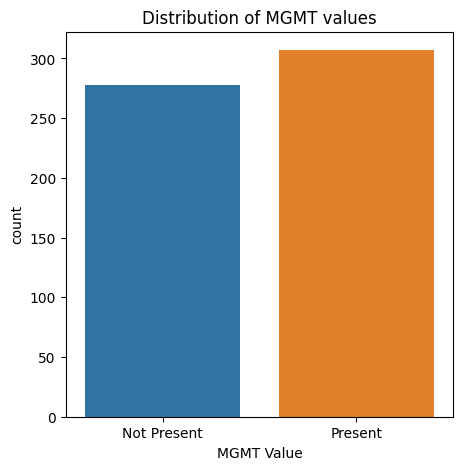

In [91]:
plt.figure(figsize=(5, 5))
sns.countplot(data=dataset, x="MGMT_value")
plt.title("Distribution of MGMT values")
plt.xlabel("MGMT Value")
plt.xticks([0, 1], ["Not Present", "Present"])
plt.show()

The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT promoter methylation for each subject in the test data.

ℹ️ **Note:** We deduce that we have to separate the sets of given train into part two part train and test for training.

In [92]:
samp_subm.head(1)

,BraTS21ID,MGMT_value
0,1,0.5


### Folders content

In [93]:
# Extract first train sample
first_folder = str(dataset.loc[0, 'BraTS21ID']).zfill(5) + "/"

# Folders content
print(
    "Folders content for all patients:", 
        json.dumps(os.listdir(train_path + first_folder), indent=4)
)

Folders content for all patients: [
    "T2w",
    "T1wCE",
    "T1w",
    "FLAIR"
]


### First patient exploration

In the first Dataset of the patient, we will explore the images contained in ['T2w', 'T1wCE', 'T1w', 'FLAIR'] of the first patient.

In [94]:
print('Number of FLAIR images:', len(os.listdir(train_path + first_folder +'FLAIR')))
print('Number of T1w images:', len(os.listdir(train_path + first_folder + 'T1w')))
print('Number of T1wCE images:', len(os.listdir(train_path + first_folder + 'T1wCE')))
print('Number of T2w images:', len(os.listdir(train_path + first_folder + 'T2w')))

Number of FLAIR images: 400
Number of T1w images: 33
Number of T1wCE images: 129
Number of T2w images: 408


ℹ️ **Summary:** 
* We deduce that we have to separate the sets of given train into part two part train and test for training.
* Report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709], we exclude this data.
* Exclusion of "/test" folder.

----

----

# Brain segmentation with mateuszbuda brain segmentation pytorch unet

#### Why
The **"mateuszbuda_brain-segmentation-pytorch_unet"** library was utilized to obtain data for our brain dataset. This library is based on the Unet neural network architecture and specifically designed for brain segmentation from medical images.

By leveraging the capabilities of this library, accurate brain segmentation was achieved on the images within our dataset. Segmentation is a critical task in medical imaging as it enables the extraction of precise information about different regions or classes, in this case, brain structures.

The selection of the **"mateuszbuda_brain-segmentation-pytorch_unet"** library was based on its exceptional performance and user-friendly nature. It provides an efficient implementation of the Unet architecture, renowned for its success in biomedical image segmentation. Consequently, our project was able to deliver reliable and accurate results for brain segmentation.

In conclusion, the utilization of the **"mateuszbuda_brain-segmentation-pytorch_unet"** library played a pivotal role in acquiring accurate brain segmentation data for our dataset. By leveraging this library, we efficiently segmented medical images and extracted valuable information to further our project's objectives.

Source: [mateuszbuda_brain-segmentation-pytorch_unet on PyTorch Hub](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

#### Library

To achieve tumor segmentation, the U-Net for Brain MRI model will be employed.

U-Net for Brain MRI is a convolutional neural network model specifically designed for segmenting brain MRI images. It features a U-shaped architecture with branch connections, comprising four levels of blocks. Each block consists of two convolution layers with batch normalization, ReLU activation function, and an encoding part with a max pooling layer, while the decoding part utilizes up-convolution. The number of convolution filters varies across the model's levels, ranging from 32 to 256.

To utilize the model, an input brain MRI image with three channels corresponding to pre-contrast, FLAIR, and post-contrast sequences should be provided. The image should be scaled to a size of 256x256 pixels and normalized using the z-score method per volume.

The pre-trained U-Net model produces a single-channel probability map indicating anomalous regions in the input image. By applying an appropriate threshold, this probability map can be converted into a binary segmentation mask.

In summary, U-Net for Brain MRI is a pre-trained model capable of automatically segmenting abnormalities in brain MRI images. Its application extends to various medical imaging tasks, including brain tumor detection and analysis.


To perform shape analysis and extract relevant features, the **"radiomics.shape2D.RadiomicsShape2D"** class will be utilized.

Source: [Radiomics.shape2D.RadiomicsShape2D ](https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D)

In [95]:
# Flag to skip brain segmentation with PyTorch UNet
# If set to True, we will import the dataset that has already been generated
skip_brain_segmentation_pytorch_unet = True

## Initialisation

Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI

In [96]:
# Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI
segmentation_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True, trust_repo=False)

The repository mateuszbuda_brain-segmentation-pytorch does not belong to the list of trusted repositories and as such cannot be downloaded. Do you trust this repository and wish to add it to the trusted list of repositories (y/N)? y


The repository is already trusted.


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [97]:
# Define "reader"
# Read serie of image files into a SimpleTK image
sitk_reader = sitk.ImageSeriesReader()
sitk_reader.LoadPrivateTagsOn()

### Dataset creation execution phase

All patients from the train_labels.csv file will be used.

In [98]:
if skip_brain_segmentation_pytorch_unet:
    dataset = pd.read_csv(dataset_path)
    
else:
    loader = widgets.IntProgress(min=0, max=len(dataset), description='Loading:')
    display(loader)
    
    # Empty creation of datasets
    init_dataset_radiomics()

    for i in dataset.BraTS21ID :
        loader.value += 1
        img_resized = get_processed_image(i)
        segmentation = segmentation_process(img_resized)
        add_patient_data(i, img_resized, segmentation)

    # Join the 3 datasets
    df_shapes = df_shapes.set_index('ID')
    df_textures = df_textures.set_index('ID')
    df_first_orders_features = df_first_orders_features.set_index('ID')

    df = df_shapes.join(df_textures).join(df_first_orders_features)

    # Define 'BraTS21ID' column as integer IDs
    df['BraTS21ID'] = df['BraTS21ID'].astype(int)
    
    # Merge the old dataset with the new one
    dataset = pd.merge(dataset, df, left_on='BraTS21ID', right_on='BraTS21ID')
    dataset.rename(columns={'BraTS21ID': 'ID'}, inplace=True)
    
# Patient BraTS21ID now is ID, and ID of Dataset
dataset = dataset.set_index('ID')
show_download_link(dataset)

<hr>

# Dataset exploration

These features provide information about various properties of brain MRI images, such as shape, texture, and grayscale statistics. They are commonly used for analysis and classification of medical images to aid in the detection and characterization of brain pathologies.

Here is the requested list of features extracted from brain MRI images:

**Shape Features:**

* **ID:** Sample identifier.
* **MeshSurface:** Mesh surface representing the object's surface using a three-dimensional mesh.
* **PixelSurface:** Surface in pixels representing the object's surface using pixels.
* **Perimeter:** Perimeter of the object, which is the length of the line surrounding the object.
* **PerimeterSurfaceRatio:** Ratio of perimeter to surface, which can provide an indication of the object's shape.
* **Sphericity:** Sphericity, measuring how closely the object resembles a perfect sphere.
* **SphericalDisproportion:** Spherical disproportion, measuring the difference between the object's shape and a perfect sphere.
* **MaximumDiameter:** Maximum diameter, which is the greatest distance between two points of the object.
* **MajorAxisLength:** Major axis length, which is the length of the object's principal axis.
* **MinorAxisLength:** Minor axis length, which is the length of the object's secondary axis.
* **Elongation:** Elongation, measuring the stretching of the object.

**Texture Features:**

* **ID:** Sample identifier.
* **Autocorrelation:** Autocorrelation, measuring the similarity between grayscale levels of an image at different positions.
* **ClusterProminence:** Cluster prominence, measuring the asymmetry and regularity of pixel values within a cluster.
* **ClusterShade:** Cluster shade, measuring the symmetry of pixel values within a cluster.
* **ClusterTendency:** Cluster tendency, measuring the similarity of pixel values within a cluster.
* **Contrast:** Contrast, measuring the brightness differences between neighboring pixels.
* **Correlation:** Correlation, measuring the linear relationship between grayscale levels of an image in different directions.
* **DifferenceAverage:** Difference average, measuring the average differences between grayscale levels of neighboring pixels.
* **DifferenceEntropy:** Difference entropy, measuring the amount of information in the differences between grayscale levels of neighboring pixels.
* **DifferenceVariance:** Difference variance, measuring the variability of differences between grayscale levels of neighboring pixels.
* **Id, Idm, Idmn, Idn, Imc1, Imc2:** These texture-specific features are computed from gray-level co-occurrence matrices and measure different properties of the distribution of gray levels in the image.
* **InverseVariance:** Inverse variance, measuring the reciprocity of gray-level variance in the image.
* **JointAverage:** Joint average, measuring the average gray levels in neighborhood relationships.
* **JointEnergy:** Joint energy, measuring the sum of squared joint gray level values.
* **JointEntropy:** Joint entropy, measuring the amount of information contained in joint gray level values.
* **MCC:** Maximum correlation coefficient, measuring the maximum correlation between grayscale levels of an image in different directions.
* **MaximumProbability:** Maximum probability, measuring the maximum probability of joint grayscale values.
* **SumAverage:** Sum average, measuring the average sum of joint gray level values.
* **SumEntropy:** Sum entropy, measuring the amount of information contained in the sums of joint gray level values.
* **SumSquares:** Sum squares, measuring the sum of squared joint gray level values.

**First-Order Features:**

* **ID:** Sample identifier.
* **MGMT_value:** Presence of MGMT.
* **10Percentile:** 10th percentile, representing the value below which 10% of the pixels are found.
* **90Percentile:** 90th percentile, representing the value below which 90% of the pixels are found.
* **Energy:** Energy, measuring the sum of squared grayscale levels of pixels.
* **Entropy:** Entropy, measuring the amount of information contained in the grayscale levels of the image.
* **InterquartileRange:** Interquartile range, which is the difference between the 75th and 25th percentiles, providing

In [99]:
dataset.head()

,MGMT_value,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,MinorAxisLenth,Elongation,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,Idm,Idmn,Idn,Imc1,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1970.0,1971.0,275.663997,0.139931,0.570766,1.752032,68.154237,63.790882,47.456975,0.743946,5.330686,3.129901,0.294966,1.017535,0.120292,0.788365,0.118948,0.528429,0.105886,0.940750,0.940660,0.992948,0.976255,-0.510210,0.827671,0.117772,2.259728,0.431742,1.696191,0.818191,0.606650,4.519456,1.571057,0.284457,106.0,137.0,28436903.0,1.153502,15.0,3.249731,161.0,9.545242,119.485033,118.0,78.0,83.0,6.540893,120.115163,0.155141,28436903.0,0.520692,150.979355
2,1,1393.0,1394.0,263.178716,0.188929,0.502724,1.989163,92.357999,61.123174,35.070076,0.573761,12.475224,2.995349,-0.580406,1.127943,0.089883,0.852171,0.089883,0.434311,0.081610,0.955059,0.955059,0.994713,0.982023,-0.605588,0.865437,0.089883,3.495097,0.405589,1.598580,0.860156,0.484062,6.990193,1.508697,0.304457,91.0,110.0,13953720.0,1.163800,10.0,8.089604,116.0,6.577396,99.626973,100.0,46.0,70.0,4.442733,100.049199,-1.587057,13953720.0,0.474834,84.308483
3,0,551.0,590.0,733.636652,1.331464,0.113423,8.816583,236.027541,188.061185,123.906694,0.658864,7.280986,12.989162,-3.688666,1.831604,0.082727,0.913079,0.082727,0.403779,0.075162,0.958637,0.958637,0.995134,0.983455,-0.657674,0.878740,0.082727,2.616039,0.507402,1.531779,0.970080,0.692817,5.232078,1.449052,0.478583,5.9,70.0,1944997.0,1.150447,16.0,4.667292,83.0,15.518207,53.510169,62.0,0.0,83.0,8.505129,57.416070,-1.655216,1944997.0,0.572094,433.266846
5,1,1538.0,1539.0,219.480231,0.142705,0.633414,1.578746,63.387696,60.362349,39.750916,0.658538,3.666557,3.059081,-0.293250,0.923751,0.056125,0.885288,0.056125,0.310386,0.052865,0.971938,0.971938,0.994388,0.985969,-0.690547,0.872664,0.056125,1.857319,0.537741,1.363675,0.899610,0.706595,3.714638,1.307551,0.244969,68.0,97.0,11069884.0,1.048471,14.0,2.563385,114.0,8.364389,84.152047,84.0,62.0,52.0,5.957969,84.811008,-0.092428,11069884.0,0.586132,111.340105
6,1,3355.0,3356.0,289.279221,0.086223,0.709797,1.408854,76.941536,68.276939,67.047725,0.981997,8.873935,5.166301,-0.096962,1.217219,0.118010,0.823130,0.116623,0.520748,0.104031,0.941920,0.941827,0.995472,0.980596,-0.547255,0.863161,0.115410,2.932428,0.428485,1.828021,0.831536,0.624847,5.864855,1.704560,0.333807,144.0,177.0,86399118.0,1.282467,17.0,3.330759,203.0,10.056196,159.935638,159.0,108.0,95.0,6.961388,160.451462,0.247894,86399118.0,0.503509,165.263438


In [100]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 0 to 1010
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MGMT_value                   585 non-null    int64  
 1   MeshSurface                  585 non-null    float64
 2   PixelSurface                 585 non-null    float64
 3   Perimeter                    585 non-null    float64
 4   PerimeterSurfaceRatio        585 non-null    float64
 5   Sphericity                   585 non-null    float64
 6   SphericalDisproportion       585 non-null    float64
 7   MaximumDiameter              585 non-null    float64
 8   MajorAxisLength              585 non-null    float64
 9   MinorAxisLenth               585 non-null    float64
 10  Elongation                   585 non-null    float64
 11  Autocorrelation              585 non-null    float64
 12  ClusterProminence            585 non-null    float64
 13  ClusterShade       

In [101]:
dataset.describe()

,MGMT_value,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,MinorAxisLenth,Elongation,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,Idm,Idmn,Idn,Imc1,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,5.850000e+02,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,5.850000e+02,585.000000,585.000000,585.000000,5.850000e+02,585.000000,585.000000,585.000000,5.850000e+02,5.850000e+02,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,5.850000e+02,585.000000,585.000000
mean,0.524786,1718.118803,1726.358974,450.439610,0.354004,0.432504,3.372908,166.000744,146.427102,88.745993,0.619874,14.069810,145.696715,-1.714195,4.646406,0.167352,0.854088,0.155957,5.929376e-01,0.135020,0.923690,0.923131,0.994455,0.976666,-0.555862,0.842267,0.147955,3.339896,0.399763,2.024826e+00,0.893870,0.542476,6.679791,1.855321e+00,1.203439,65.665812,122.752991,1.953437e+07,1.443847e+00,30.900427,8.317241,154.374359,19.491796,94.591956,95.082051,32.736752,121.637607,14.655667,100.926104,-0.146737,1.953437e+07,0.469990,879.400708
std,0.499813,1037.787779,1034.724165,360.639463,0.319726,0.209852,2.479368,96.590299,105.212652,69.847424,0.163543,10.429510,273.919318,26.202413,5.667876,0.100039,0.107134,0.084005,2.296638e-01,0.070969,0.040214,0.040798,0.003726,0.011041,0.146991,0.137340,0.076087,1.340557,0.210350,7.996771e-01,0.109903,0.198721,2.681115,7.118198e-01,1.423966,46.176449,40.302703,1.998142e+07,5.506597e-01,32.676448,43.928820,34.904690,14.648434,39.196048,44.888371,36.352711,46.838274,14.577544,34.302708,2.119495,1.998142e+07,0.185586,1101.421810
min,0.000000,336.500000,339.000000,101.740115,0.066495,0.088739,1.153183,37.696154,32.852100,19.514556,0.146047,1.000000,0.000000,-154.862845,0.000000,0.000000,0.407452,0.000000,-3.203427e-16,0.000000,0.787172,0.779284,0.964512,0.937082,-0.962827,0.000000,0.000000,1.000000,0.078222,-3.203427e-16,0.407452,0.155082,2.000000,-3.203427e-16,0.000000,0.000000,0.000000,0.000000e+00,-3.203427e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.782140,0.000000e+00,0.156984,0.000000
25%,0.000000,926.000000,933.000000,240.651804,0.134912,0.230365,1.677946,83.677954,68.589900,42.051500,0.513756,6.116817,5.001610,-4.848048,1.131784,0.093083,0.791871,0.091259,4.396395e-01,0.084217,0.897134,0.896627,0.992812,0.968907,-0.643788,0.803644,0.090075,2.348328,0.248040,1.528974e+00,0.823772,0.390295,4.696656,1.429116e+00,0.311615,0.000000,106.000000,6.763936e+06,1.084208e+00,12.000000,2.666161,131.000000,9.247074,74.760280,78.000000,0.000000,85.000000,5.656749,82.606684,-1.026970,6.763936e+06,0.332189,150.979355
50%,1.000000,1494.000000,1499.000000,324.391919,0.201608,0.456797,2.189158,130.942736,91.641829,54.637606,0.637999,11.075012,24.713607,-0.180180,2.277056,0.159446,0.869822,0.154463,6.237762e-01,0.133668,0.923440,0.923291,0.995002,0.976849,-0.537934,0.877845,0.149874,3.147750,0.350270,2.094593e+00,0.906714,0.500670,6.295499,1.919738e+00,0.620722,76.900000,128.000000,1.395372e+07,1.462362e+00,20.000000,3.696146,158.000000,14.531348,99.710803,104.000000,18.000000,122.000000,9.075066,103.123679,-0.200525,1.395372e+07,0.436518,404.220293
75%,1.000000,2284.000000,2286.000000,485.972655,0.497056,0.595967,4.340936,257.608230

ℹ️ **Summary:**
* No null values
* The variables **"MGMT_value", "MeshSurface", "PixelSurface", "Perimeter", and "MaximumDiameter"** appear to be continuous quantitative measures.
* The variables **"PerimeterSurfaceRatio", "Sphericity", "SphericalDisproportion", "Elongation", "Autocorrelation", "ClusterProminence", "ClusterShade", "ClusterTendency", "Contrast", "Correlation", "DifferenceAverage", "DifferenceEntropy", "DifferenceVariance", "Idm", "Idmn", "Idn", "Imc1", "Imc2", "InverseVariance", "JointAverage", "JointEnergy", "JointEntropy", "MCC", "MaximumProbability", "SumAverage", "SumEntropy", "SumSquares", "Energy", "Entropy", "InterquartileRange", "Kurtosis", "MeanAbsoluteDeviation", "Median", "Range", "RobustMeanAbsoluteDeviation", "RootMeanSquared", "Skewness", "TotalEnergy", "Uniformity", "Variance"** appear to be texture measures or features extracted from images.
* The variable **"MGMT_value"** has a mean of 0.524786 and a standard deviation of 0.499813, indicating a bimodal distribution with slight positive skewness.
* The surface variables **"MeshSurface" and "PixelSurface"** appear to have a considerable range, with values ranging from 336.5 to 6565.
* The variable **"Perimeter"** has a mean of 450.439610 and a standard deviation (std) of 360.639463, indicating a relatively high dispersion of values. A relatively high spread of values means that object boundaries vary. The individual values can be far from the mean, which induces a great variability in the sizes and shapes of the objects present in the images.
* The shape variables **"Sphericity", "SphericalDisproportion", "Elongation"** have mean values around 0.4 to 0.6, indicating a generally non-spherical shape of the depicted objects. (Brain)
* The variable **"Mean"** has a mean of 879.400708 and a standard deviation of 1101.421810, indicating a relatively high variability in the mean values of the images. This suggests that the images show great diversity in their average values, resulting from different characteristics of the objects and the capture conditions.
* The variable **"Minimum"** has a minimum value of 0, suggesting the possible presence of outliers or black pixels in the images. (See in previous Summary, [00109, 00123, 00709])

----

# TODO Yannick

# First patient

In [102]:
premiere_ligne = dataset.iloc[:1]

# Convertir la première ligne en dictionnaire
premiere_ligne_dict = premiere_ligne.to_dict(orient="records")[0]

# Formater l'affichage des colonnes et valeurs
affichage_formate = "\n".join([f"{colonne}: {valeur}" for colonne, valeur in premiere_ligne_dict.items()])

# Afficher toutes les colonnes et valeurs
print(affichage_formate)

MGMT_value: 1
MeshSurface: 1970.0
PixelSurface: 1971.0
Perimeter: 275.6639969244296
PerimeterSurfaceRatio: 0.1399309629058018
Sphericity: 0.5707658706605531
SphericalDisproportion: 1.7520318775239485
MaximumDiameter: 68.15423684555495
MajorAxisLength: 63.79088163718111
MinorAxisLenth: 47.456974950621714
Elongation: 0.7439460583181684
Autocorrelation: 5.330686111440979
ClusterProminence: 3.1299014101848663
ClusterShade: 0.2949656947477074
ClusterTendency: 1.0175351255387302
Contrast: 0.1202920106904142
Correlation: 0.7883651276364155
DifferenceAverage: 0.1189478685851452
DifferenceEntropy: 0.5284288881583875
DifferenceVariance: 0.1058857532277353
Id: 0.940750089391639
Idm: 0.9406604799179544
Idmn: 0.992947719525951
Idn: 0.9762552310198132
Imc1: -0.5102102978917968
Imc2: 0.8276705311619313
InverseVariance: 0.1177717442430348
JointAverage: 2.2597279037453197
JointEnergy: 0.4317424864046278
JointEntropy: 1.6961912652982036
MCC: 0.8181913824750047
MaximumProbability: 0.6066502444094464
SumA

ℹ️
- ID et BraTS21ID sont de même

In [103]:
#init_dataset_radiomics()
#img_resized = get_processed_image(0)
#segmentation = segmentation_process(img_resized)
#show_segmentation(img_resized,segmentation)
#add_patient_data(0,img_resized,segmentation)
#print(df_shapes.head()) 
#print(df_textures.head())
#print(df_first_orders_features.head())

# todo add targe into dateset

----


# Analysis

# Table TODO

> 

### Correlation Matrix

In [ ]:
correlation_matrix = dataset.corr()

fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(correlation_matrix, ax=ax, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Correlation Matrix with Strong correlation

As a rule of correlation threshold:
* 0.00-0.19: very weak.
* 0.20-0.39: weak.
* 0.40-0.59: moderate.
* 0.60-0.79: strong.
* 0.80-1.00: very strong.

We will use 0.7, strong.

In [ ]:
correlation_threshold = 0.7
# Filtrer by correlation threshold
filtered_correlation_matrix = filter_correlation_matrix(correlation_matrix, correlation_threshold)

fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(filtered_correlation_matrix, ax=ax, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Correlation group with threshold strength

For correlation threshold equal to **0.7, strong.**

In [ ]:
correlation_threshold = 0.7
groups_correlated_threshold_07 = find_highly_correlated_groups(correlation_matrix, correlation_threshold)

for group_correlated in groups_correlated_threshold_07:
    if len(group_correlated) > 1:
        print(group_correlated)

For correlation threshold equal to **0.99, very strong.**

In [ ]:
correlation_threshold = 0.99
groups_correlated_threshold_099 = find_highly_correlated_groups(correlation_matrix, correlation_threshold)

for group_correlated in groups_correlated_threshold_099:
    if len(group_correlated) > 1:
        print(group_correlated)

### Analyse univariée

Test de normalité utilisé : Shapiro-Wilk : Puissant et précis, recommandé pour les échantillons de petite taille

Teste le skewness : mesure l'assymétrie d'une série (0 si suit loi normale). Lorsque la Skewness est égal à 0, le dataset est symétrique. Mais cette mesure nous renseigne aussi sur le type d’asymétrie.

Teste le kurtosis : mesure l'applatissement (vaut 3 si loi normale de Laplace) mais on utilise aussi l'excédent de Kurtosis. Si le Kurtosis est supérieur à 3, alors l’ensemble de données est leptokurtique, c’est-à-dire que les queues sont plus épaisses que la normale. Cela indique un regroupement d’outliers.

Si le Kurtosis est inférieur à 3, alors l’ensemble de données est platykurtique, c’est-à-dire que les queues sont plus fines que la normale. Cela indique un excès négatif d’outlier. En d’autres termes, la plupart des données ont tendance à se rassembler autour de la moyenne.

Lorsque le Kurtosis est égal à 3, alors l’ensemble de données est mésokurtique, c’est-à-dire que les queues sont les mêmes que dans une distribution normale.

Graphiques utilisés :

    histogramme avec courbe de densité de probabilité (le point rouge indique la moyenne)
    boxplot
    QQ plot (diagramme Quantile-Quantile) : permet d'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique.

<h3>Dataset complet</h3>

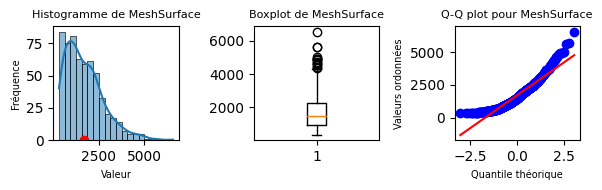

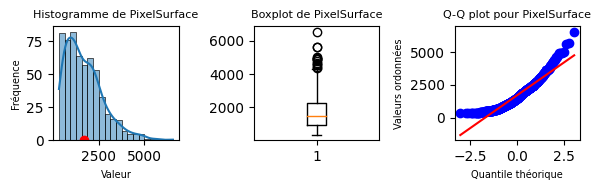

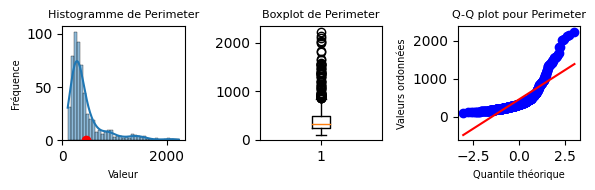

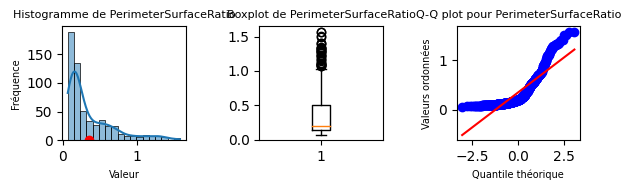

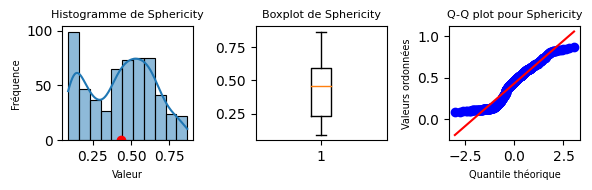

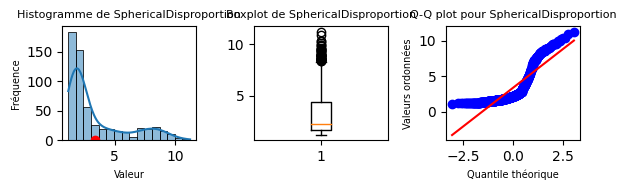

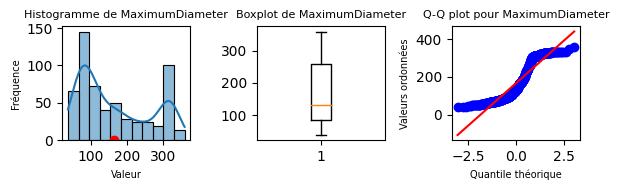

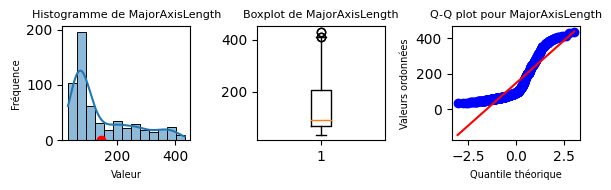

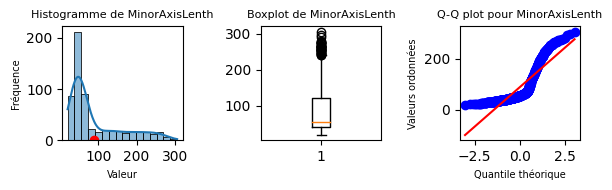

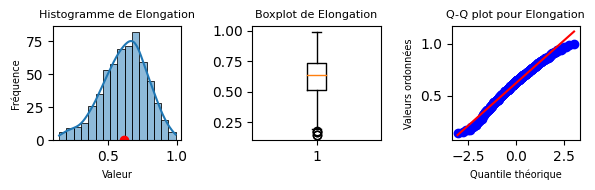

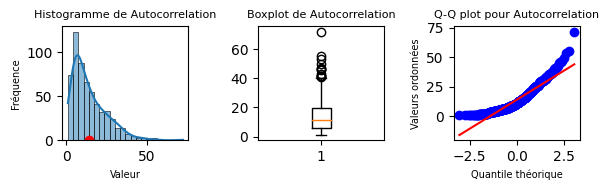

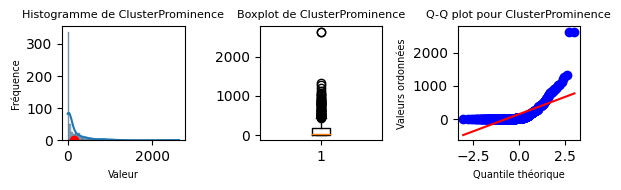

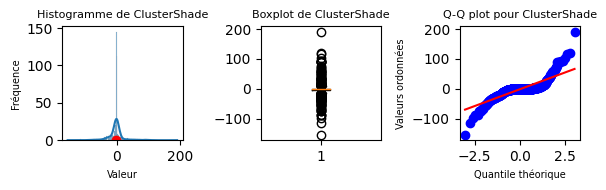

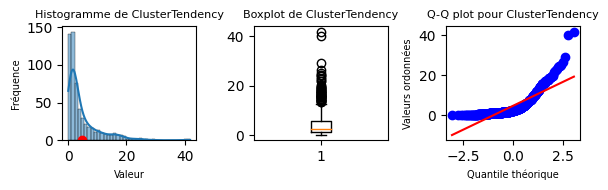

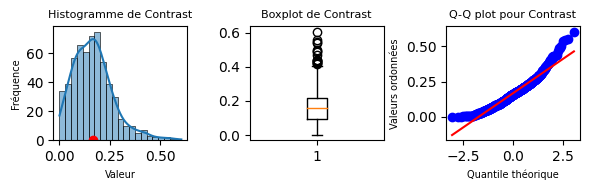

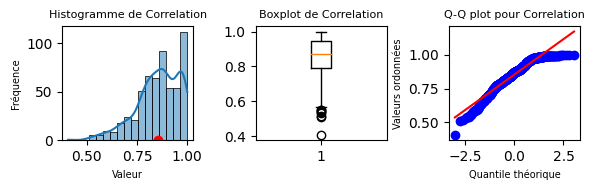

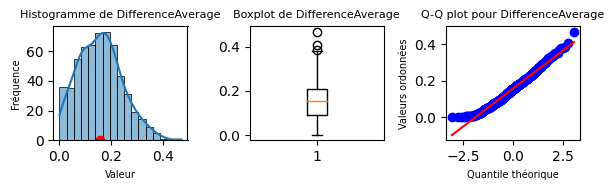

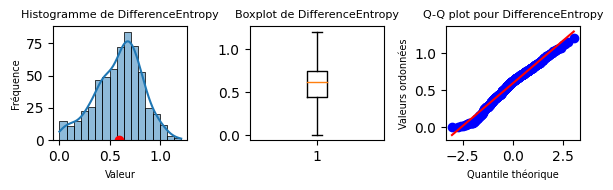

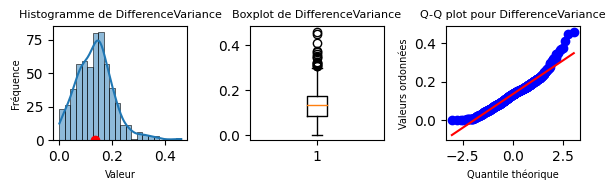

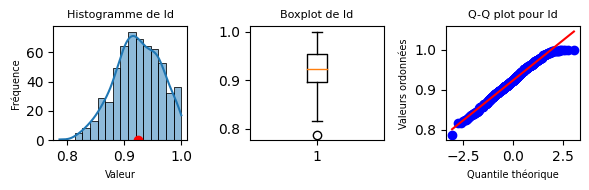

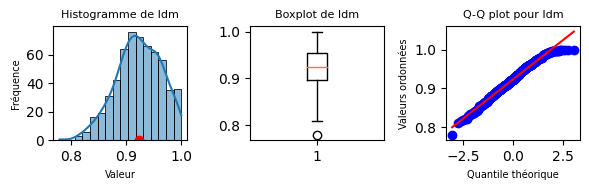

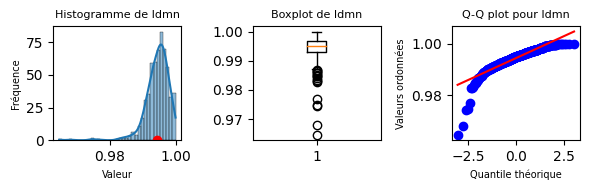

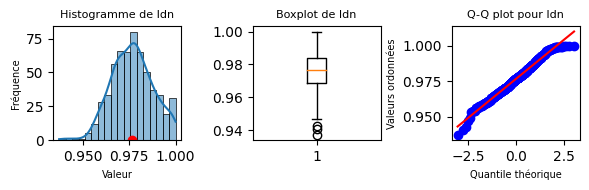

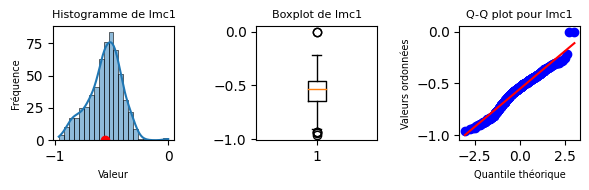

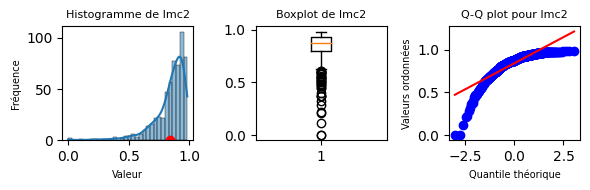

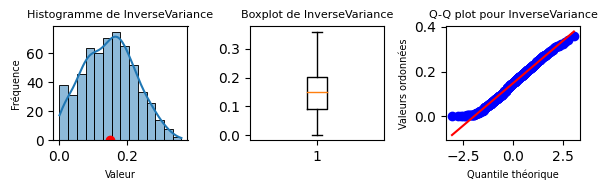

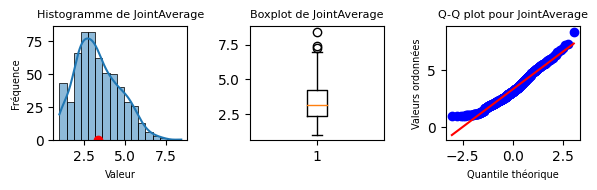

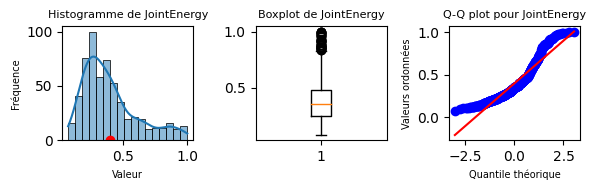

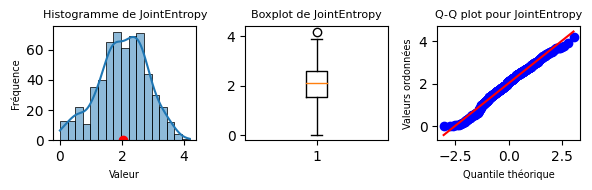

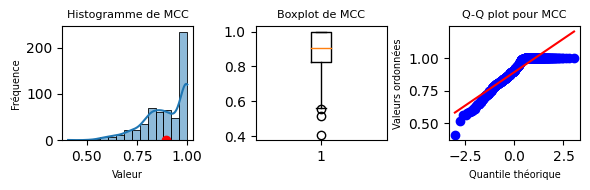

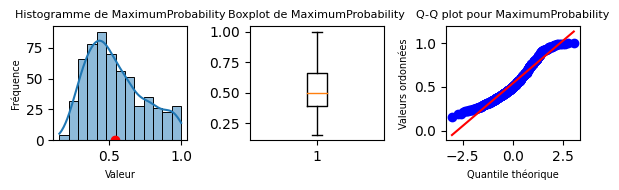

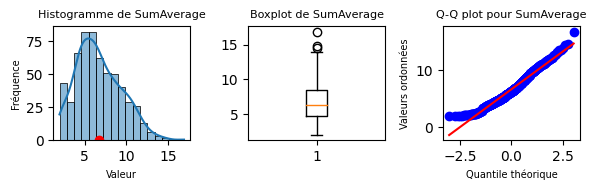

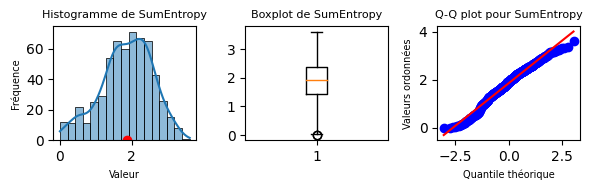

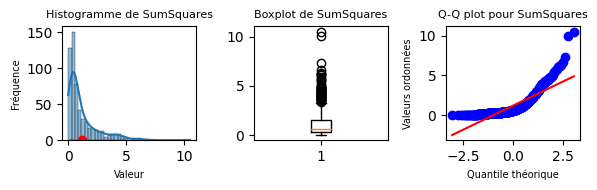

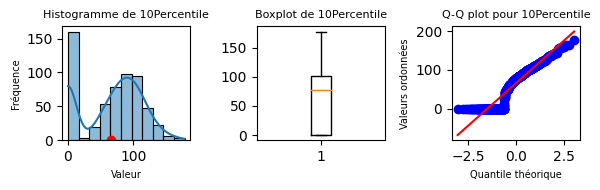

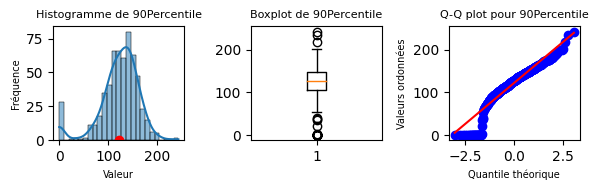

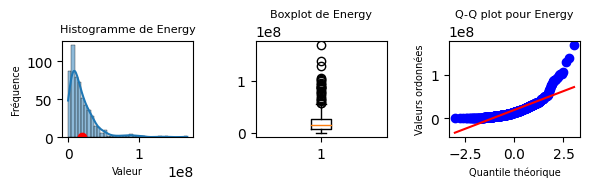

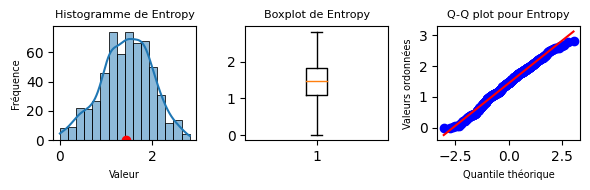

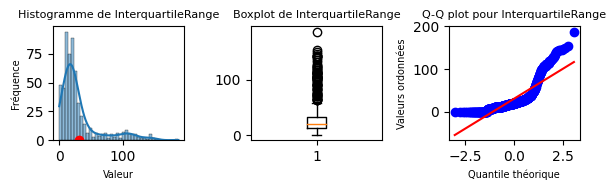

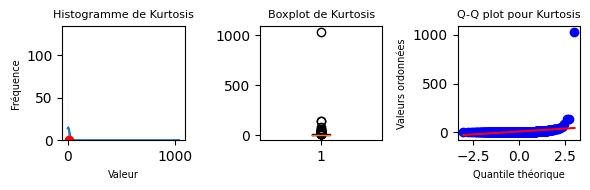

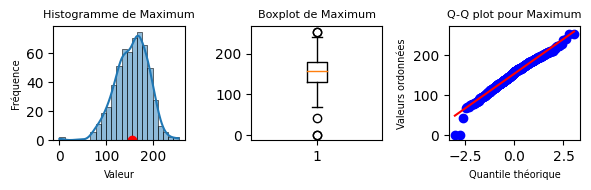

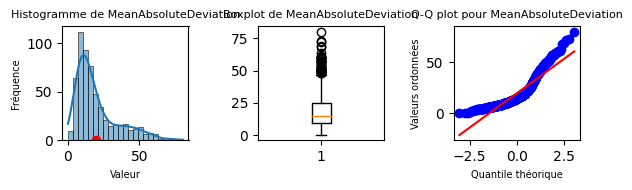

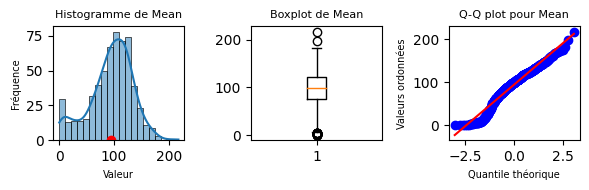

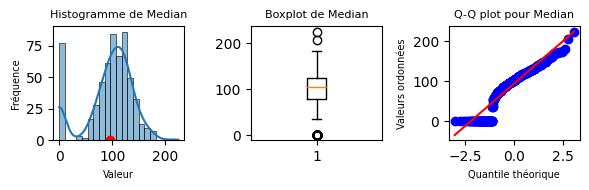

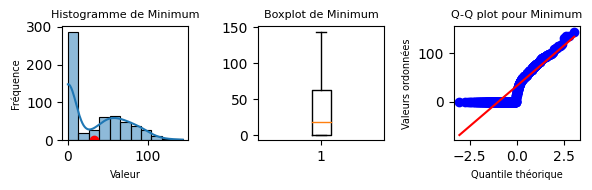

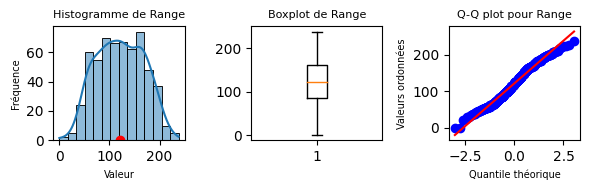

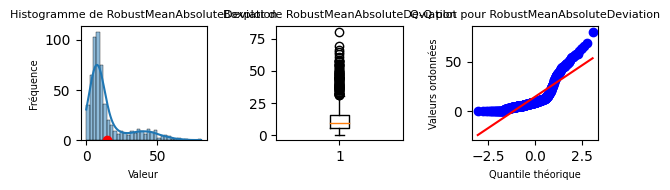

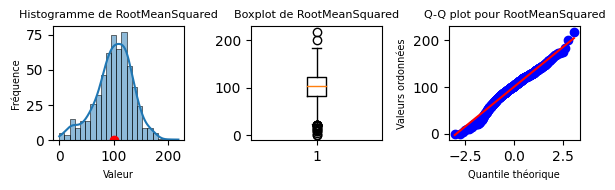

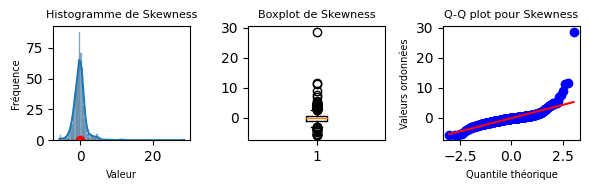

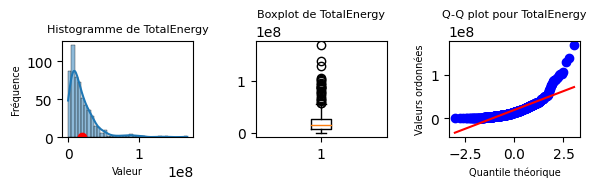

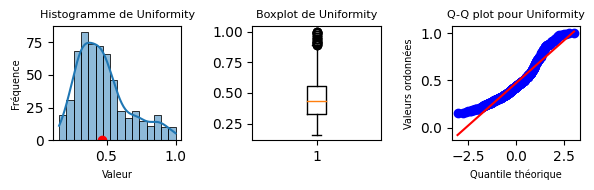

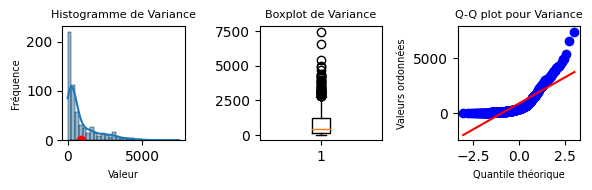

Description dataset complet


,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,MinorAxisLenth,Elongation,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,Idm,Idmn,Idn,Imc1,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
count,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0,585.0
mean,1718.118803,1726.358974,450.43961,0.354004,0.432504,3.372908,166.000744,146.427102,88.745993,0.619874,14.06981,145.696715,-1.714195,4.646406,0.167352,0.854088,0.155957,0.592938,0.13502,0.92369,0.923131,0.994455,0.976666,-0.555862,0.842267,0.147955,3.339896,0.399763,2.024826,0.89387,0.542476,6.679791,1.855321,1.203439,65.665812,122.752991,19534374.923077,1.443847,30.900427,8.317241,154.374359,19.491796,94.591956,95.082051,32.736752,121.637607,14.655667,100.926104,-0.146737,19534374.923077,0.46999,879.400708
std,1037.787779,1034.724165,360.639463,0.319726,0.209852,2.479368,96.590299,105.212652,69.847424,0.163543,10.42951,273.919318,26.202413,5.667876,0.100039,0.107134,0.084005,0.229664,0.070969,0.040214,0.040798,0.003726,0.011041,0.146991,0.13734,0.076087,1.340557,0.21035,0.799677,0.109903,0.198721,2.681115,0.71182,1.423966,46.176449,40.302703,19981417.898769,0.55066,32.676448,43.92882,34.90469,14.648434,39.196048,44.888371,36.352711,46.838274,14.577544,34.302708,2.119495,19981417.898769,0.185586,1101.42181
min,336.5,339.0,101.740115,0.066495,0.088739,1.153183,37.696154,32.8521,19.514556,0.146047,1.0,0.0,-154.862845,0.0,0.0,0.407452,0.0,-0.0,0.0,0.787172,0.779284,0.964512,0.937082,-0.962827,0.0,0.0,1.0,0.078222,-0.0,0.407452,0.155082,2.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.78214,0.0,0.156984,0.0
25%,926.0,933.0,240.651804,0.134912,0.230365,1.677946,83.677954,68.5899,42.0515,0.513756,6.116817,5.00161,-4.848048,1.131784,0.093083,0.791871,0.091259,0.43964,0.084217,0.897134,0.896627,0.992812,0.968907,-0.643788,0.803644,0.090075,2.348328,0.24804,1.528974,0.823772,0.390295,4.696656,1.429116,0.311615,0.0,106.0,6763936.0,1.084208,12.0,2.666161,131.0,9.247074,74.76028,78.0,0.0,85.0,5.656749,82.606684,-1.02697,6763936.0,0.332189,150.979355
50%,1494.0,1499.0,324.391919,0.201608,0.456797,2.189158,130.942736,91.641829,54.637606,0.637999,11.075012,24.713607,-0.18018,2.277056,0.159446,0.869822,0.154463,0.623776,0.133668,0.92344,0.923291,0.995002,0.976849,-0.537934,0.877845,0.149874,3.14775,0.35027,2.094593,0.906714,0.50067,6.295499,1.919738,0.620722,76.9,128.0,13953720.0,1.462362,20.0,3.696146,158.0,14.531348,99.710803,104.0,18.0,122.0,9.075066,103.123679,-0.200525,13953720.0,0.436518,404.220293
75%,2284.0,2286.0,485.972655,0.497056,0.595967,4.340936,257.60823,205.833779,121.31062,0.736002,19.806487,178.903716,0.794732,5.861259,0.219093,0.945646,0.208296,0.750977,0.172535,0.95472,0.954642,0.996851,0.9841,-0.45685,0.933348,0.201567,4.247946,0.480843,2.574224,1.0,0.662628,8.495893,2.362117,1.520686,101.0,147.0,26106595.0,1.825819,32.0,6.257369,179.0,24.448801,120.924012,123.0,63.0,160.0,15.863436,123.119305,0.405612,26106595.0,0.554491,1210.133793
max,6565.0,6563.0,2236.89567,1.573866,0.867165,11.268996,359.918046,432.662145,306.081351,0.992449,72.01654,2637.192756,191.603312,41.901808,0.6064,1.0,0.468927,1.208627,0.459972,1.0,1.0,1.0,1.0,0.0,0.984922,0.360694,8.439091,1.0,4.185711,1.0,1.0,16.878182,3.613585,10.518336,178.0,243.0,169038681.0,2.817311,188.0,1035.846945,254.0

In [126]:
describe=fonc_test_normality(dataset.drop('MGMT_value',axis=1))

print("Description dataset complet")
describe

<h3>Analyse sur l'ensemble du dataset, remarques :</h3>

Le jeu de données montre que les les valeurs cibles sont homogènes.

Aucune des variables ne répond au test de Shapiro-Wilk indiquant que les variables explicatives ne suivent pas une loi normale.

Variables ayant un skewness correct : Sphericity, Elongation, Idn, Range,

Variables ayant un bon kurtosis : MajorAxisLength, Elongation, DifferenceAverage, DifferenceEntropy, Idn, JointAverage, SumAverage, Mean,

En analysant les graphiques, variables semblant bonnes sur le Q-Q plot sans trop de valeurs extrêmes : Elongation, DifferenceAverage, DifferenceEntropy, JointEntropy, SumEntropy, Entropy, Maximum, Range

Mais cela ne signifie pas que le dataset soit mauvais, il permet de faire ressortir les variables avec des valeurs extrêmes.

Elongation, Idn et Range semblent être homogènes.

<h3>Mêmes calculs mais que pour les MGMT_value = 1</h3>

In [109]:
describe_MGMT_1=fonc_test_normality(dataset[dataset.MGMT_value == 1].drop('MGMT_value',axis=1),graphic=False)

In [110]:
print("Description du dataset pour MGMT_value = 1")
describe_MGMT_1

Description du dataset pour MGMT_value = 1


,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,MinorAxisLenth,Elongation,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,Idm,Idmn,Idn,Imc1,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
count,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0,307.0
mean,1730.495114,1738.925081,458.212649,0.353843,0.435192,3.411276,169.967969,151.641263,91.762557,0.616947,13.877829,155.542557,-2.112491,4.938623,0.162568,0.858093,0.151043,0.582032,0.132123,0.926154,0.925596,0.994775,0.977686,-0.56462,0.843198,0.143034,3.307931,0.405099,2.000368,0.899492,0.545996,6.615862,1.835969,1.275298,62.861889,120.841042,18877975.729642,1.436774,32.775244,9.586569,154.397394,20.227466,92.449935,93.226384,31.04886,123.348534,15.459043,99.313954,-0.065136,18877975.729642,0.472993,949.337166
std,1012.513162,1009.474294,367.745804,0.317435,0.219095,2.505799,99.846747,107.640637,72.572074,0.165866,10.096585,253.718023,25.176566,5.867059,0.098797,0.109247,0.082125,0.228251,0.070872,0.039187,0.039784,0.003321,0.010374,0.14993,0.13409,0.073841,1.321306,0.211522,0.799751,0.108623,0.200172,2.642613,0.714304,1.474839,46.964468,40.460642,18393450.548362,0.556335,35.716865,59.248101,34.331883,15.690625,38.775332,44.305646,36.72768,47.745776,16.003601,33.695601,2.335759,18393450.548362,0.187566,1162.384146
min,336.5,339.0,117.740115,0.066495,0.096658,1.172299,37.696154,32.8521,21.643629,0.146047,1.0,0.0,-113.207594,0.0,0.0,0.513338,0.0,-0.0,0.0,0.816123,0.809628,0.968063,0.946771,-0.962827,0.0,0.0,1.0,0.102962,-0.0,0.559245,0.193091,2.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.679622,0.0,0.15707,0.0
25%,946.75,956.0,244.480231,0.132761,0.222437,1.663712,84.338977,68.269575,41.541962,0.514018,5.952414,5.026501,-4.924238,1.11229,0.092018,0.792035,0.090417,0.435798,0.083404,0.899012,0.898614,0.992971,0.970319,-0.661328,0.801483,0.088626,2.341662,0.253757,1.496399,0.831826,0.397112,4.683323,1.40455,0.304336,0.0,106.0,7546188.0,1.067228,12.0,2.574013,130.0,8.982392,72.623342,77.0,0.0,85.0,5.429948,81.289818,-1.008427,7546188.0,0.335967,148.39922
50%,1494.0,1502.0,325.705627,0.200201,0.471329,2.121659,132.034087,94.272353,54.685078,0.62224,11.575215,24.661577,-0.240241,2.23812,0.15319,0.875224,0.150013,0.611239,0.129387,0.926772,0.925999,0.995355,0.97779,-0.551272,0.877457,0.141217,3.154156,0.349931,2.077505,0.922016,0.501424,6.308313,1.917015,0.6073,73.0,126.0,13271453.0,1.463623,20.0,3.798122,156.0,14.458401,96.688081,101.0,0.0,124.0,8.840505,100.957985,-0.176885,13271453.0,0.436518,401.398033
75%,2283.75,2285.0,516.922402,0.51609,0.601067,4.495658,278.989021,236.561478,131.849394,0.736083,19.271491,198.294651,0.942895,6.43907,0.21329,0.9575,0.205356,0.739452,0.16756,0.955654,0.955637,0.996933,0.984401,-0.464871,0.934683,0.196178,4.180431,0.483962,2.530591,1.0,0.666108,8.360861,2.324188,1.659978,100.5,146.25,26054081.0,1.810626,32.0,6.597526,182.0,24.941104,118.754104,120.25,61.0,161.5,15.786535,120.782422,0.404496,26054081.0,0.560445,1383.176609
max,5621.5,5623.0,2236.89567,1.573866,0.853025,10.345787,350.138544,413.087191,306.081351,0.992449,53.344101,1316.710071,118.174463,28.974011,0.554211,1.0,0.407008,1.152763,0.448643,1.0,1.0,1.0,1.0,0.0,0.984922,0.341331,7.273088,1.0,3.895053,1.0,1.0,14.546175,3.347672,7.2843,178.0,243.0,128908009.0,2.782627,150.0,1

<h3>Comparaison des kurtosis et skewness</h3>

In [111]:
print("complet")
describe.loc[['skewness','excess_kurtosis'],:]

complet


,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,MinorAxisLenth,Elongation,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,Idm,Idmn,Idn,Imc1,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
skewness,1.094549,1.10363,2.296072,1.669332,-0.075345,1.338672,0.554839,1.110597,1.360128,-0.388686,1.305061,3.926479,0.843122,2.358341,0.951541,-0.833278,0.37307,-0.3454,0.778428,-0.253134,-0.292844,-2.519363,-0.040854,-0.307544,-2.347259,0.112669,0.505697,1.085668,-0.273024,-0.959076,0.560782,0.505697,-0.381271,2.332827,-0.247677,-1.143437,2.773895,-0.214196,1.993352,22.041574,-0.445174,1.40668,-0.533925,-0.868048,0.609763,0.010869,1.698941,-0.4067,5.156418,2.773895,0.905472,2.018454
excess_kurtosis,1.383115,1.402759,5.546336,2.238562,-1.072409,0.459764,-1.211991,-0.034855,0.570317,-0.074498,2.148305,24.382511,11.214505,7.320389,1.512803,0.520636,-0.116294,-0.156441,1.723191,-0.355641,-0.277191,13.816065,-0.126287,0.269881,7.98219,-0.595269,-0.146906,0.493832,-0.218974,0.539886,-0.56394,-0.146906,-0.212034,7.159875,-1.102649,2.245069,11.37506,-0.247894,3.502405,510.754063,0.76171,1.423076,0.135992,0.340036,-0.912982,-0.847336,2.180401,0.425621,61.495574,11.37506,0.280185,4.700848


In [ ]:
print("MGMT = 1")
describe_MGMT_1.loc[['skewness','excess_kurtosis'],:]

MGMT = 1


,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,MinorAxisLenth,Elongation,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,Idm,Idmn,Idn,Imc1,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
skewness,0.974054,0.983798,2.261338,1.625918,-0.037099,1.245755,0.455624,0.943434,1.26323,-0.365169,1.15397,2.148534,0.598233,1.734732,0.999993,-0.830261,0.397533,-0.286206,0.842002,-0.271405,-0.31136,-2.302702,-0.001917,-0.195094,-2.055784,0.125211,0.449534,1.035189,-0.213018,-0.964673,0.543636,0.449534,-0.313303,1.722498,-0.148575,-1.189369,2.396524,-0.125368,1.728409,17.016178,-0.374851,1.289715,-0.463188,-0.832079,0.713837,0.001236,1.50231,-0.350978,6.343787,2.396524,0.828875,1.579795
excess_kurtosis,0.805118,0.825399,5.418095,2.180216,-1.179854,0.211874,-1.374934,-0.464159,0.320733,-0.1268,1.160182,4.446383,6.502181,2.326527,1.553955,0.271653,-0.174376,-0.19488,1.817463,-0.410775,-0.338137,13.547829,-0.305747,0.166062,6.496969,-0.631695,-0.243043,0.291833,-0.310414,0.230523,-0.642217,-0.243043,-0.324725,2.289133,-1.187494,2.22043,7.766865,-0.386515,1.875489,292.14413,0.675293,0.644454,0.211762,0.390112,-0.839546,-0.927138,1.033566,0.598147,74.26881,7.766865,0.02724,1.65138


Certaines variables ont un meilleur skewness avec un MGMT à 1 que par rapport au dataset global et inversement, ces mêmes variables sont donc sensibles au marqueurs. De même le Kurtosis est sensible aussi. Suivant les variables, la corrélation est positive ou négative entre skewness et kurtosis.

In [ ]:
print("Par variable, variation avec MGMT_value=1 par rapport au dataset global")
for col in describe.columns :
    skew = (describe_MGMT_1.loc['skewness',col]*100/describe.loc['skewness',col])-100
    kurt = (describe_MGMT_1.loc['excess_kurtosis',col]*100/describe.loc['excess_kurtosis',col])-100
    print (f"{col:<32} : skewness {skew:>8.2f}%, excess_kurtosis {kurt:>8.2f}%")

Par variable, variation avec MGMT_value=1 par rapport au dataset global
MeshSurface                      : skewness   -11.01%, excess_kurtosis   -41.79%
PixelSurface                     : skewness   -10.86%, excess_kurtosis   -41.16%
Perimeter                        : skewness    -1.51%, excess_kurtosis    -2.31%
PerimeterSurfaceRatio            : skewness    -2.60%, excess_kurtosis    -2.61%
Sphericity                       : skewness   -50.76%, excess_kurtosis    10.02%
SphericalDisproportion           : skewness    -6.94%, excess_kurtosis   -53.92%
MaximumDiameter                  : skewness   -17.88%, excess_kurtosis    13.44%
MajorAxisLength                  : skewness   -15.05%, excess_kurtosis  1231.70%
MinorAxisLenth                   : skewness    -7.12%, excess_kurtosis   -43.76%
Elongation                       : skewness    -6.05%, excess_kurtosis    70.21%
Autocorrelation                  : skewness   -11.58%, excess_kurtosis   -46.00%
ClusterProminence                : sk

Une première conclusion pourrait être qu'un gliocome dont la valeur du MGMT = 0 présenterait des variables contenant plus d'outliers.

Il y a des exceptions avec des variation semblant abbérantes comme l'excess de kurtosis pour la variable MajorAxisLength qui explose avec une augmentation de presque 1232%.

Ces variations pourrait indiquer les variables ayant un impact plus important par rapport à la valeur cible. Par Exemple Sphericity à moins d'outliers avec MGMT_value à 1, une meilleur normalité d'Idn.

In [ ]:
# Comparaison avec MGMT_value = 0
describe_MGMT_0 = fonc_test_normality(dataset[dataset.MGMT_value == 0].drop('MGMT_value',axis=1),graphic=False)
print("Par variable, variation avec MGMT_value=0 par rapport au dataset global")
for col in describe.columns :
    skew = (describe_MGMT_0.loc['skewness',col]*100/describe.loc['skewness',col])-100
    kurt = (describe_MGMT_0.loc['excess_kurtosis',col]*100/describe.loc['excess_kurtosis',col])-100
    print (f"{col:<32} : skewness {skew:>8.2f}%, excess_kurtosis {kurt:>8.2f}%")

Par variable, variation avec MGMT_value=0 par rapport au dataset global
MeshSurface                      : skewness    10.60%, excess_kurtosis    37.33%
PixelSurface                     : skewness    10.46%, excess_kurtosis    36.77%
Perimeter                        : skewness     1.65%, excess_kurtosis     2.27%
PerimeterSurfaceRatio            : skewness     2.71%, excess_kurtosis     2.55%
Sphericity                       : skewness    85.81%, excess_kurtosis   -11.49%
SphericalDisproportion           : skewness     8.05%, excess_kurtosis    65.98%
MaximumDiameter                  : skewness    20.76%, excess_kurtosis   -18.67%
MajorAxisLength                  : skewness    18.44%, excess_kurtosis -1754.60%
MinorAxisLenth                   : skewness     8.21%, excess_kurtosis    52.19%
Elongation                       : skewness     6.41%, excess_kurtosis   -81.26%
Autocorrelation                  : skewness     9.67%, excess_kurtosis    35.20%
ClusterProminence                : sk

<h3>Exemple : comparaison de Sphericity, Entropy, ClusterProminence
afin de vérifier la normalité en fonction de la valeur cible

Sphericity pour MGMT_value=1


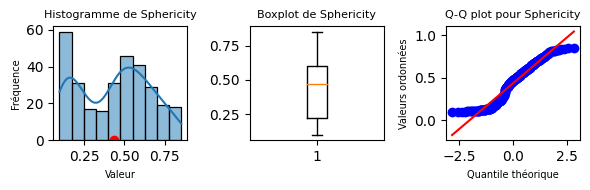

Sphericity pour MGMT_value=0


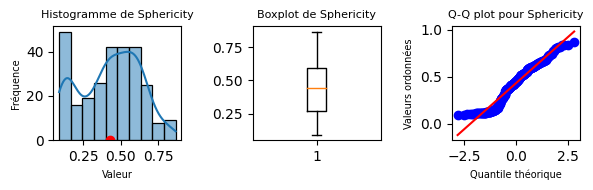

Entropy pour MGMT_value=1


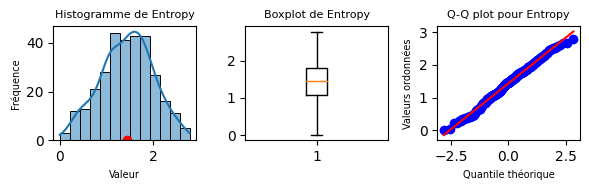

Entropy pour MGMT_value=0


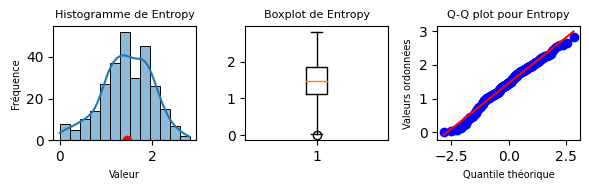

ClusterProminence pour MGMT_value=1


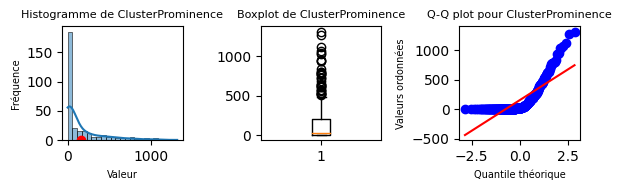

ClusterProminence pour MGMT_value=0


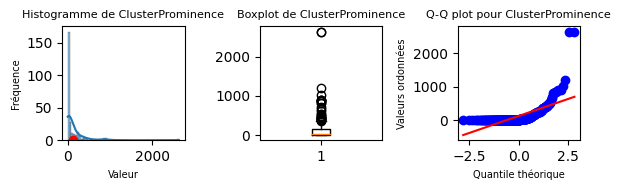

,ClusterProminence
count,278.0
mean,134.82379
std,294.705711
min,0.0
25%,5.014091
50%,24.866686
75%,150.038858
max,2637.192756
skewness,5.167403
kurtosis,39.195256


In [128]:
print("Sphericity pour MGMT_value=1")
fonc_test_normality(dataset[dataset.MGMT_value == 1][['Sphericity']],graphic=True)      

print("Sphericity pour MGMT_value=0")
fonc_test_normality(dataset[dataset.MGMT_value == 0][['Sphericity']],graphic=True)   

print("Entropy pour MGMT_value=1")
fonc_test_normality(dataset[dataset.MGMT_value == 1][['Entropy']],graphic=True)      

print("Entropy pour MGMT_value=0")
fonc_test_normality(dataset[dataset.MGMT_value == 0][['Entropy']],graphic=True)  

print("ClusterProminence pour MGMT_value=1")
fonc_test_normality(dataset[dataset.MGMT_value == 1][['ClusterProminence']],graphic=True)      

print("ClusterProminence pour MGMT_value=0")
fonc_test_normality(dataset[dataset.MGMT_value == 0][['ClusterProminence']],graphic=True)

<h3>Détection des outliers</h3>
Utilisation du IQR (interquartile range)

In [ ]:
q1=dataset.quantile(0.25)
q3=dataset.quantile(0.75)

IQR=q3-q1

outliers = dataset[((dataset<(q1-1.5*IQR)) | (dataset>(q3+1.5*IQR)))]
outliers

outliers_removed = outliers.dropna().reset_index()
print(outliers_removed)

Empty DataFrame
Columns: [ID, MGMT_value, MeshSurface, PixelSurface, Perimeter, PerimeterSurfaceRatio, Sphericity, SphericalDisproportion, MaximumDiameter, MajorAxisLength, MinorAxisLenth, Elongation, Autocorrelation, ClusterProminence, ClusterShade, ClusterTendency, Contrast, Correlation, DifferenceAverage, DifferenceEntropy, DifferenceVariance, Id, Idm, Idmn, Idn, Imc1, Imc2, InverseVariance, JointAverage, JointEnergy, JointEntropy, MCC, MaximumProbability, SumAverage, SumEntropy, SumSquares, 10Percentile, 90Percentile, Energy, Entropy, InterquartileRange, Kurtosis, Maximum, MeanAbsoluteDeviation, Mean, Median, Minimum, Range, RobustMeanAbsoluteDeviation, RootMeanSquared, Skewness, TotalEnergy, Uniformity, Variance]
Index: []


# ----

In [ ]:
# TODO

In [ ]:
#TODO

In [ ]:
#TODO

In [ ]:
#TODO

In [ ]:
#TODO

# Etape 3/ Nettoyage et Pre-processing :

In [ ]:
#TODO

In [ ]:
#TODO

In [ ]:
#TODO